# HAR Experiment using LSTM
- data source: combined data from 2 data collection sessions
- preprocessing:

    1. Remove pilot and null subcarriers from raw data
    2. Hampel filter
    3. DWT
        - decomposition level: max
        - method: **sym5**
    
- train test split of 80:20.
- validation split during training is 0.2
- train model
- test model

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
os.getcwd()

'd:\\fyp_mds5\\model'

In [3]:
# define list of pilot and null subcarriers for 20MHz
remove_subcarrier_cols = [x+32 for x in [-21, -7, 21,  7, -32, -31, -30, -29, 31,  30,  29,  0]]
remove_subcarrier_cols.sort()

## Read Activity Files

In [4]:
# generate iterator of jpg files in a list of directories
def data_files_iter(dir):
    for file in os.listdir(dir):
        if file.endswith(".csv"):
            fname = os.path.join(dir, file)
            components = fname.split("\\")[-1]
            fname_tokens = components.split("_")
            label, idx = fname_tokens[0], fname_tokens[1]
            yield fname, label

In [5]:
file_lst = os.listdir(r"..\dataset\230510_combined_data")

## Data Preparation

In [6]:
def read_files(activity_data):
    csi_results = []
    lgt_results = []
    for i in range(len(activity_data)):
        df = pd.read_csv(activity_data[i], sep=",", header=None)
        arr = df.values
        csi_results.append(arr[:, :64])
        lgt_results.append(arr[:, -9:])
    return csi_results, lgt_results

def get_label(activity, label):
    list_y = []
    for i in range(len(activity)):
        list_y.append(label)
    return np.array(list_y).reshape(-1, 1) 

In [7]:
all_data_files = [(f, lbl) for f, lbl in data_files_iter(r"..\dataset\230510_combined_data")]
empty_files = [tup[0] for tup in all_data_files if tup[1] == 'empty']
stand_files = [tup[0] for tup in all_data_files if tup[1] == 'stand']
sit_files = [tup[0] for tup in all_data_files if tup[1] == 'sit']
walk_files = [tup[0] for tup in all_data_files if tup[1] == 'walk']

In [8]:
empty_csi, empty_lgt = read_files(empty_files)
stand_csi, stand_lgt = read_files(stand_files)
sit_csi, sit_lgt = read_files(sit_files)
walk_csi, walk_lgt = read_files(walk_files)

empty_label = get_label(empty_csi, 'empty')
stand_label = get_label(stand_csi, 'stand')
sit_label = get_label(sit_csi, 'sit')
walk_label = get_label(walk_csi, 'walk')

## Preprocess

In [9]:
def get_csi_preconditioned(data):
    return np.delete(data, remove_subcarrier_cols, axis=1)

In [10]:
def median_absolute_deviation(x):
    """
    Returns the median absolute deviation from the window's median

    Args:
        x: Values in the window
    Returns:
        The median absolute deviatino (MAD) of x
    """
    return np.median(np.abs(x - np.median(x)))

def hampel(ts, window_size=3, t0=3):
    """
    Args:
        ts
        window_size
        t0: threshold
    Ref:
        1. https://github.com/MichaelisTrofficus/hampel_filter
    """
    # Make copy so original not edited
    vals = pd.Series(ts.copy())

    # constant scale factor for Hampel Filter
    L = 1.4826
    
    # calculate median absolute deviation
    rolling_ts = vals.rolling(window_size, center=True)
    rolling_median = rolling_ts.median().fillna(method='bfill').fillna(method='ffill')
    rolling_sigma = L*(rolling_ts.apply(median_absolute_deviation).fillna(method='bfill').fillna(method='ffill'))

    outliers_idx_lst = list(
        np.array(np.where(np.abs(vals - rolling_median) >= (t0 * rolling_sigma))).flatten())

    # replace outliers with rolling median
    vals[outliers_idx_lst] = rolling_median[outliers_idx_lst]

    # print("vals: ", vals.shape)
    return vals.to_numpy()

In [11]:
import pywt

def dwt_denoise(vals, scheme):
    data = vals.copy()
    w = pywt.Wavelet(scheme)
    max_level = pywt.dwt_max_level(len(data), w.dec_len) # level=3
    coeffs = pywt.wavedec(data, scheme, max_level)

    # for i in range(1, len(coeffs)):
    #     coeffs[i] = pywt.threshold(coeffs[i], threshold * np.max(coeffs[i]))

    rec_vals = pywt.waverec(coeffs, scheme)
    return rec_vals

In [12]:
# apply preprocessing steps
def preprocess_csi(csi_data_lst):
    for i in range(len(csi_data_lst)):
        temp = get_csi_preconditioned(csi_data_lst[i])
        temp = np.apply_along_axis(hampel, 1, temp)
        temp  = dwt_denoise(temp, scheme='sym5')
        csi_data_lst[i] = temp
    return csi_data_lst

In [13]:
empty_csi = preprocess_csi(empty_csi)
stand_csi = preprocess_csi(stand_csi)
sit_csi = preprocess_csi(sit_csi)
walk_csi = preprocess_csi(walk_csi)

## Concatenate data across activities and shuffle data

In [14]:
# concatenate all samples
csi_X = np.vstack((empty_csi, stand_csi, sit_csi, walk_csi))
lgt_X = np.vstack((empty_lgt, stand_lgt, sit_lgt, walk_lgt))
# concatenate all labels
y = np.vstack((empty_label, stand_label, sit_label, walk_label))

In [15]:
# randomise samples
from sklearn.utils import shuffle
csi_X, lgt_X, y = shuffle(csi_X, lgt_X, y, random_state=5)

## Split train and test datasets

In [16]:
from sklearn.model_selection import train_test_split
csi_X_train, csi_X_test, lgt_X_train, lgt_X_test, y_train, y_test = train_test_split(csi_X, lgt_X, y, test_size=0.2, random_state=5)

In [17]:
## one-hot encode labels
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train).toarray()
y_test = ohe.transform(y_test).toarray()

In [18]:
from pickle import dump

# save preprocessing objects
obj_save_dir = 'v3_obj'
if not os.path.exists(obj_save_dir):
    os.makedirs(obj_save_dir)
dump(ohe, open(f'{obj_save_dir}/ohe.pkl', 'wb'))

## LSTM model

In [122]:
def create_activity_model():
    csi_input = tf.keras.layers.Input(shape=(100, 52), name="csi_input")
    lgt_input = tf.keras.layers.Input(shape=(100, 9), name="light_input")
    merged_input = tf.keras.layers.concatenate([csi_input, lgt_input], axis=2, name="merged_input")
    # normalized_input = tf.keras.layers.Normalization()(merged_input)
    x = tf.keras.layers.LSTM(units=48, input_shape= merged_input[-2,:].shape)(merged_input)
    x = tf.keras.layers.Dropout(rate=0.1)(x)
    x = tf.keras.layers.Dense(units=16, activation='relu')(x)
    output = tf.keras.layers.Dense(y_train.shape[1], activation='softmax')(x) #Softmax converts a real vector to a vector of 
                                                                  #categorical probabilities
                                                                    # output shape (number of classes) 
    model = tf.keras.Model(inputs=[csi_input, lgt_input], outputs=output)
    return model

activity_model = create_activity_model()

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

opt = tf.keras.optimizers.Adam(learning_rate=1e-8)

activity_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


model_history = activity_model.fit([csi_X_train, lgt_X_train], y_train, epochs= 150, validation_split=0.2,  batch_size=16, callbacks = [lr_schedule])

Epoch 1/150
9/9 [==============================] - 2s 66ms/step - loss: 1.3670 - accuracy: 0.3015 - val_loss: 1.2618 - val_accuracy: 0.5294 - lr: 1.0000e-08
Epoch 2/150
9/9 [==============================] - 0s 12ms/step - loss: 1.3530 - accuracy: 0.2500 - val_loss: 1.2618 - val_accuracy: 0.5294 - lr: 1.1220e-08
Epoch 3/150
9/9 [==============================] - 0s 11ms/step - loss: 1.3553 - accuracy: 0.2794 - val_loss: 1.2618 - val_accuracy: 0.5294 - lr: 1.2589e-08
Epoch 4/150
9/9 [==============================] - 0s 12ms/step - loss: 1.3614 - accuracy: 0.3088 - val_loss: 1.2618 - val_accuracy: 0.5294 - lr: 1.4125e-08
Epoch 5/150
9/9 [==============================] - 0s 12ms/step - loss: 1.3552 - accuracy: 0.2868 - val_loss: 1.2618 - val_accuracy: 0.5294 - lr: 1.5849e-08
Epoch 6/150
9/9 [==============================] - 0s 12ms/step - loss: 1.3761 - accuracy: 0.3015 - val_loss: 1.2618 - val_accuracy: 0.5294 - lr: 1.7783e-08
Epoch 7/150
9/9 [==============================] - 0s 11ms

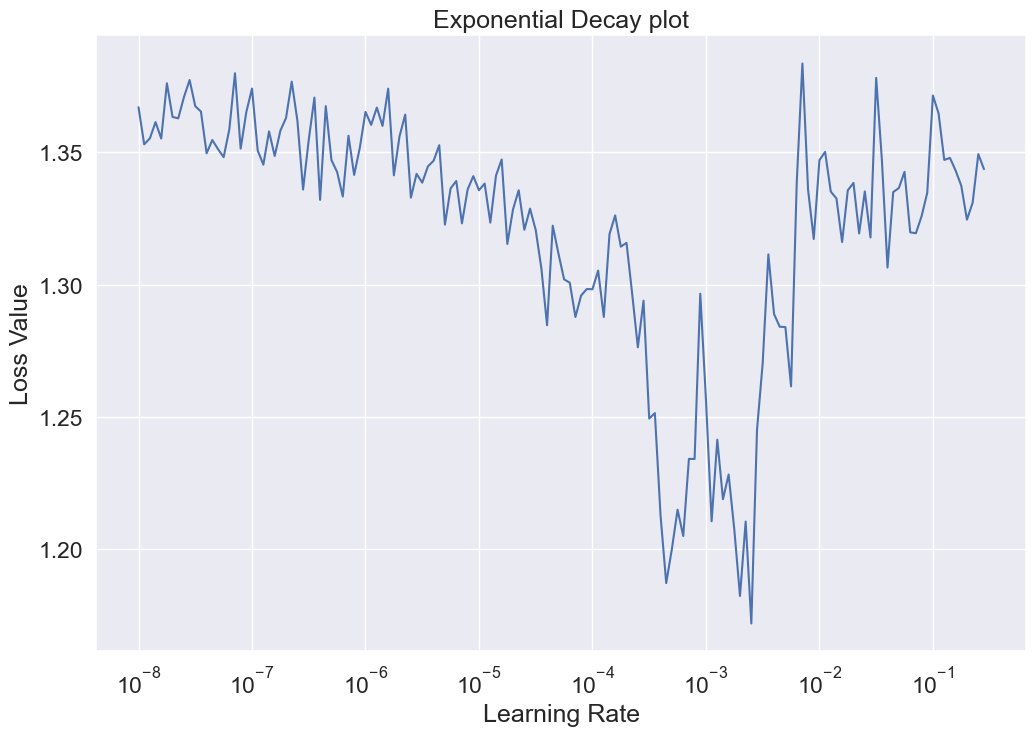

In [124]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

# Exponential Decay Plot
figure(figsize=(12, 8))
plt.semilogx(model_history.history["lr"], np.array(model_history.history["loss"]))
sns.set(font_scale=1.5)
plt.ylabel('Loss Value')
plt.xlabel('Learning Rate')
plt.title('Exponential Decay plot')
plt.show()

In [125]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.98):
            print("\nAccuracy has reached to threshold (98%) so stopping training!")
            self.model.stop_training = True

callbacks = myCallback()

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30)

model = create_activity_model()
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [126]:
history = model.fit([csi_X_train, lgt_X_train], y_train, epochs= 500, batch_size=16, validation_split = 0.2, callbacks = [callbacks, earlystopping])

Epoch 1/500
9/9 [==============================] - 2s 69ms/step - loss: 1.5808 - accuracy: 0.2721 - val_loss: 1.5318 - val_accuracy: 0.1765
Epoch 2/500
9/9 [==============================] - 0s 23ms/step - loss: 1.5513 - accuracy: 0.3382 - val_loss: 1.5114 - val_accuracy: 0.2059
Epoch 3/500
9/9 [==============================] - 0s 22ms/step - loss: 1.5668 - accuracy: 0.2721 - val_loss: 1.4908 - val_accuracy: 0.2059
Epoch 4/500
9/9 [==============================] - 0s 22ms/step - loss: 1.5157 - accuracy: 0.2868 - val_loss: 1.4790 - val_accuracy: 0.2353
Epoch 5/500
9/9 [==============================] - 0s 20ms/step - loss: 1.4923 - accuracy: 0.3529 - val_loss: 1.4716 - val_accuracy: 0.2059
Epoch 6/500
9/9 [==============================] - 0s 17ms/step - loss: 1.5134 - accuracy: 0.3088 - val_loss: 1.4627 - val_accuracy: 0.2059
Epoch 7/500
9/9 [==============================] - 0s 17ms/step - loss: 1.4575 - accuracy: 0.3529 - val_loss: 1.4556 - val_accuracy: 0.2059
Epoch 8/500
9/9 [===

In [127]:
y_pred = model.predict([csi_X_test, lgt_X_test]) #prediction on test data set

model.evaluate([csi_X_test, lgt_X_test], y_test)

2/2 [==============================] - 0s 14ms/step - loss: 1.0379 - accuracy: 0.5581


[1.0379321575164795, 0.5581395626068115]

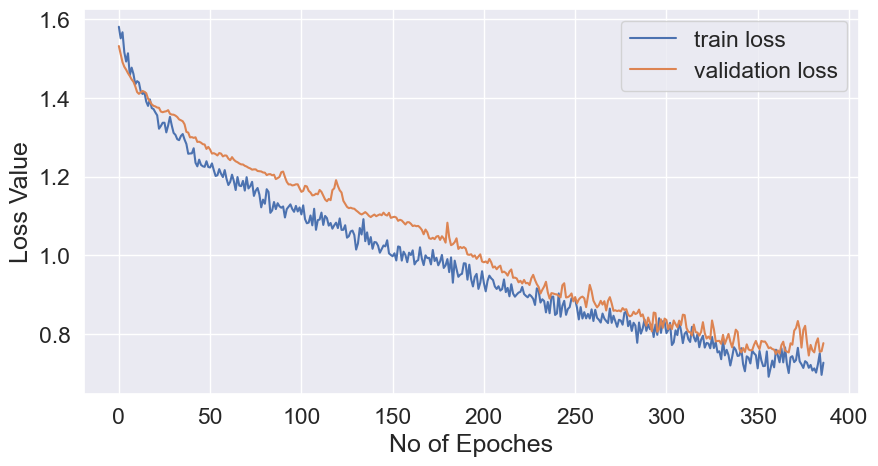

In [128]:
# plot history
figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.ylabel('Loss Value')
plt.xlabel('No of Epoches')
plt.legend()
plt.show()

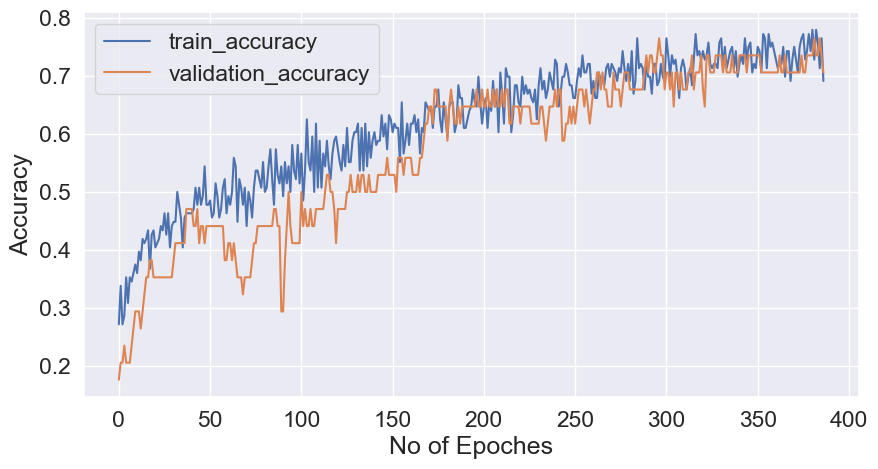

In [129]:
# plot history
figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='validation_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No of Epoches')
plt.legend()
plt.show()

In [130]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
index = ['Empty', 'sit', 'stand','walk']
columns = ['Empty', 'sit', 'stand','walk']
df_cm = pd.DataFrame(confusion_matrix,columns,index) 

Text(0.5, 16.156249999999993, 'Predicted Activities')

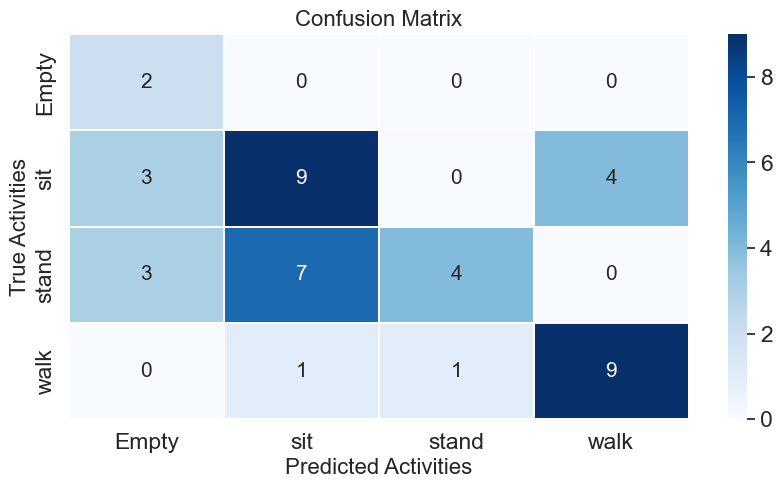

In [131]:
sns.set(font_scale=1.5)
figure(figsize=(10, 5))
sns.heatmap(df_cm, annot=True, cmap='Blues', linewidths=0.2,annot_kws={"fontsize":15})
plt.title("Confusion Matrix", fontsize=16)
plt.ylabel('True Activities', fontsize=16)
plt.xlabel('Predicted Activities', fontsize=16)

In [132]:
from sklearn.metrics import classification_report
target_names = ['Empty', 'sit', 'stand','walk']
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=target_names)) 

              precision    recall  f1-score   support

       Empty       0.25      1.00      0.40         2
         sit       0.53      0.56      0.55        16
       stand       0.80      0.29      0.42        14
        walk       0.69      0.82      0.75        11

    accuracy                           0.56        43
   macro avg       0.57      0.67      0.53        43
weighted avg       0.65      0.56      0.55        43



In [133]:
# save model
model.save('v3_model')

INFO:tensorflow:Assets written to: v3_model\assets


INFO:tensorflow:Assets written to: v3_model\assets


Conclusion:

The preprocessing of V3 model returns the best performance for training and validation loss. Using dropout layer avoids overfitting problem as seen in the trained models from the V1 and V2 notebooks.

Next steps:
- experiment if using pilot and null subcarriers improves model performance